# Comparing the Performance of Various Classifiers on Handwritten Digits Datasets
#### By Jonathan L. Moran (jo6155mo-s@student.lu.se)
From the EDAN95 - Applied Machine Learning course given at Lunds Tekniska Högskola (LTH) | Ht2 2019.

_In this post we will implement an NCC, a discrete (count-based) NBC, and a Gaussian NBC and run and compare them on different versions of the data set(s) in Section 2:_

## 1. Classifiers

### 1.1. SciKitLearn Gaussian Naive Bayes Classifier
Make use of the provided Gaussian NB Classifier (`sklearn.naive_bayes GaussianNB`) for all data sets as a comparison.

In [1]:
from sklearn.naive_bayes import GaussianNB

In [2]:
class sklearnGNB:
    def fit(self, X_train, y_train):
        self.model = GaussianNB()
        self.model.fit(X_train, y_train)
        return self.model
    def predict(self, X_test):
        return self.model.predict(X_test)

### 1.2. Nearest Centroid Classifier
Implement your own Nearest Centroid Classifier (NCC): The NCC `fit` method should simply compute the mean values over the attribute values of the examples for each class. Prediction is then done by finding the `argmin` over the distances from the class centroids for each sample. This classifier should be run on all three variants of data sets, see below.

In [3]:
import numpy as np

In [4]:
class NCC:
    def fit(self, X_train, y_train):
        n_samples, n_features = X_train.shape
        self._classes = np.unique(y_train)
        n_classes = len(self._classes)
        self._centroids = np.zeros(shape=(n_classes, n_features))
        # Compute the per-class centroids (means)
        for cls in self._classes:
            idxs = np.where(y_train==cls)    # fetch all samples per label (class)
            # compute the mean value of each 16-bit image 
            self._centroids[cls] = np.mean(X_train[idxs], axis=0)
        return self    
    def predict(self, X_test):
        preds = np.zeros(shape=(len(X_test), n_classes))
        for i, x in enumerate(X_test):
            # compute dist to per-class centers
            preds[i] = [np.linalg.norm(x - centroid) for centroid in self._centroids]
        y_pred = np.argmin(preds, axis=1)
        return y_pred

### 1.3. Naive Bayes Classifier
Implement a Naive Bayesian Classifier (NBC) based on discrete (statistical) values (i.e., counts of examples falling into the different classes and attribute value groups) both for the priors and for the conditional probabilities. Run this on the two SciKitLearn `digits` data sets. It should also work with the (non-normalised) `MNIST_Light` set, but it will probably take a (very long) while and not give anything interesting really...

In [5]:
from itertools import product

In [6]:
class NBC:
    def fit(self, X_train, y_train, data="digits"):
        n_samples, n_rows, n_cols = np.shape(X_train)
        self._classes, self.class_counts = np.unique(y_train, return_counts=True)
        # 1. Compute class priors: digit frequency
        class_priors = self.class_counts / np.sum(self.class_counts)
        # 2. Compute attribute likelihoods
        likelihoods = {}
        pixel_values = np.unique(X_train.flatten())
        for cls in self._classes:
            # store class atrribute frequencies
            cls_pixels = {}
            # get all samples in current class
            idxs = np.where(y_train == cls)
            # iterate over each image and its coordinates
            for k, (i,j) in enumerate(product(range(n_rows), range(n_cols))):
                # store attribute value counts (number of occurences)
                cls_pixel_counts = np.zeros(shape=len(pixel_values))
                # get attribute value at pixel location and count num occurences in current class
                loc, num_occurences = np.unique(X_train[idxs][:,i,j], return_counts=True)
                # store attribute value class occurences for every pixel location in image
                cls_pixel_counts[loc.astype(np.int8)] = num_occurences
                # compute attribute value class frequencies
                if data is "digits":
                    # with Laplace smoothing
                    freq = (cls_pixel_counts + 1) / np.sum(cls_pixel_counts + 1)
                else:
                    freq = cls_pixel_counts / np.sum(cls_pixel_counts)
                cls_pixels.update({k:freq})
            likelihoods[cls] = cls_pixels
        self._likelihoods = likelihoods
        self._class_priors = class_priors
        self._data = data
        return self
    def predict(self, X_test):
        n_samples, n_rows, n_cols = np.shape(X_test)
        y_pred = np.zeros(shape=len(X_test))
        for n, x in enumerate(X_test):
            posterior = np.zeros(len(self._classes))
            for cls in self._classes:
                prob = self._class_priors[cls]
                for k, (i,j) in enumerate(product(range(n_rows), range(n_cols))):
                    # 3. Compute conditional probability of seeing pixel value at location (i,j) in image k 
                    prob *= self._likelihoods[cls][k][int(x[i,j])]
                posterior[cls] = self._class_priors[cls] * prob
            y_pred[n] = np.argmax(posterior)
        return y_pred

### 1.4. Gaussian Naive Bayes Classifier

In [7]:
import math

In [8]:
class GNBC:
    def log_likelihood(self, x, mu, sigma):
        epsilon = 1e-4
        coeff = 1.0 / np.sqrt(2.0 * math.pi * sigma + epsilon)
        exponent = math.exp(-1.0 * (x - mu)**2 / (2.0 * sigma + epsilon))
        return np.log(coeff * exponent)
    def fit(self, X_train, y_train):
        self._classes, self.class_counts = np.unique(y_train, return_counts=True)
        # 1. Compute class priors
        self._class_priors = self.class_counts / np.sum(self.class_counts)
        # 2. Compute Gaussian distribution parameters
        means = {}
        vars = {}
        for cls in self._classes:
            # get all samples in class
            idxs = np.where(y_train == cls)
            # compute class mean
            cls_mean = np.mean(X_train[idxs], axis=0)
            means.update({cls:cls_mean})
            # compute class variance
            cls_var = np.var(X_train[idxs], axis=0)
            vars.update({cls:cls_var})
        self._means = means
        self._vars = vars
    def predict(self, X_test):
        y_pred = np.zeros(len(X_test))
        log_likelihood = np.vectorize(self.log_likelihood)
        for i, x in enumerate(X_test):
            probs = np.zeros(len(self._classes))
            for cls in self._classes:
                # P(Y): class prior (frequency in training set)
                prior = self._class_priors[cls]
                # P(X|Y): probability of X given class distribution Y
                prob = log_likelihood(x, self._means[cls], self._vars[cls])
                # P(Y|X) = P(Y)*P(X|Y)
                posterior = prior * np.sum(prob)
                probs[cls] = posterior
            y_pred[i] = np.argmax(probs)
        return y_pred

## 2. Datasets

### 2.1. SciKitLearn Digits

Recall that the `digits` dataset consists of 1797 samples. Each sample is an 8x8 image of a single handwritten digit from 0 to 9. Each sample therefore has 64 features, where each of the 64 features is a brightness value of a pixel in the image.

In [9]:
from sklearn.datasets import load_digits

In [10]:
digits = load_digits()

In [11]:
# Classes in dataset
classes = np.unique(digits.target)
n_classes = len(classes)

In [12]:
import matplotlib.pyplot as plt

In [13]:
def visualize_random(images, labels, examples_per_class):
    """
    Display random sample of images per class
    """
    number_of_classes = len(np.unique(labels))
    
    for cls in range(number_of_classes):
        idxs = np.where(labels == cls)[0]
        idxs = np.random.choice(idxs, examples_per_class, replace=False)
        for i, idx in enumerate(idxs):
            plt.subplot(examples_per_class, number_of_classes, i * number_of_classes + cls + 1)
            plt.imshow(images[idx].astype('uint8'), cmap=plt.cm.gray_r, interpolation='nearest')
            plt.axis('off')
            if i == 0:
                plt.title(str(cls))
    plt.show()

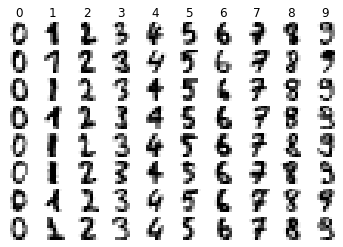

In [14]:
visualize_random(digits.images, digits.target, 8)

In [15]:
def mean_image(images, labels, dim):
    """
    Display mean image of each class
    """
    # Assume 10 classes, dimxdim image data
    cls_means = np.zeros(shape=(10,dim,dim))
    for cls in range(n_classes):
        idxs = np.where(labels == cls)[0]
        cls_means[cls] = np.mean(images[idxs], axis=0)
        plt.subplot(1, n_classes, cls + 1)
        plt.axis('off')
        plt.imshow(cls_means[cls].astype('uint8'), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(str(cls))
    plt.show()

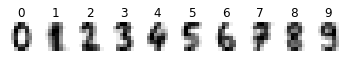

In [16]:
mean_image(digits.images, digits.target, dim=8)

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(digits.images, digits.target, test_size=0.3)

In [19]:
# Normalise image data
X_train = X_train / 16.0
X_test = X_test / 16.0

#### 2.1.1. SciKitLearn Gaussian Naive Bayes Classifier

In [20]:
# Reshape data to 2D
X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))

In [21]:
sklearnGNB = sklearnGNB()

In [22]:
sklearnGNB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [23]:
y_pred = sklearnGNB.predict(X_test)

In [24]:
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix

SciKitLearn Guassian Naive Bayes Classifier on digits dataset... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        61
           1       0.71      0.90      0.80        52
           2       0.96      0.50      0.66        54
           3       0.89      0.70      0.79        47
           4       0.91      0.86      0.89        50
           5       0.95      0.90      0.93        62
           6       0.96      0.94      0.95        54
           7       0.76      0.96      0.85        52
           8       0.48      0.80      0.60        50
           9       1.00      0.67      0.80        58

    accuracy                           0.83       540
   macro avg       0.86      0.82      0.82       540
weighted avg       0.87      0.83      0.83       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6f6b9ad0>)

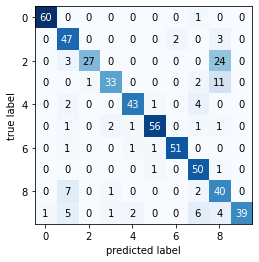

In [25]:
print('SciKitLearn Guassian Naive Bayes Classifier on digits dataset... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

#### 2.1.2. Nearest Centroid Classifier

In [26]:
ncc = NCC()

In [27]:
ncc.fit(X_train, y_train)

In [28]:
y_pred = ncc.predict(X_test)

Nearest Centroid Classifier on digits dataset... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        61
           1       0.78      0.73      0.75        52
           2       0.91      0.94      0.93        54
           3       0.93      0.89      0.91        47
           4       0.96      0.92      0.94        50
           5       0.93      0.89      0.91        62
           6       0.96      0.96      0.96        54
           7       0.86      0.98      0.92        52
           8       0.84      0.72      0.77        50
           9       0.77      0.86      0.81        58

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.89      0.89      0.89       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6ee9f610>)

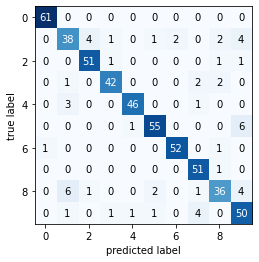

In [29]:
print('Nearest Centroid Classifier on digits dataset... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

#### 2.1.3. Naive Bayes Classifier

In [30]:
n_samples, n_pixels = X_train.shape
dim = int(np.sqrt(n_pixels))

In [31]:
# Reshape data to 3D
X_train_nbc = X_train.reshape((len(X_train), dim, dim))
X_test_nbc = X_test.reshape((len(X_test), dim, dim))

In [32]:
X_train_nbc.shape

(1257, 8, 8)

In [33]:
nbc = NBC()

In [34]:
nbc.fit(X_train_nbc, y_train)

In [35]:
y_pred = nbc.predict(X_test_nbc)

Naive Bayes Classifier on digits dataset... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.22      1.00      0.36        61
           1       1.00      0.17      0.30        52
           2       0.00      0.00      0.00        54
           3       0.00      0.00      0.00        47
           4       0.00      0.00      0.00        50
           5       1.00      0.05      0.09        62
           6       0.43      0.11      0.18        54
           7       0.82      0.17      0.29        52
           8       0.12      0.56      0.20        50
           9       0.00      0.00      0.00        58

    accuracy                           0.21       540
   macro avg       0.36      0.21      0.14       540
weighted avg       0.37      0.21      0.14       540

----------Confusion Matrix----------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6ee34390>)

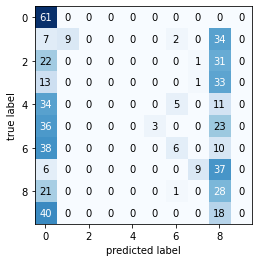

In [36]:
print('Naive Bayes Classifier on digits dataset... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

#### 2.1.4. Gaussian Naive Bayes Classifier

In [37]:
gnbc = GNBC()

In [38]:
gnbc.fit(X_train, y_train)

In [39]:
y_pred = gnbc.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Gaussian Naive Bayes Classifier on digits dataset... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        61
           1       0.79      0.87      0.83        52
           2       0.92      0.87      0.90        54
           3       0.78      0.91      0.84        47
           4       0.92      0.94      0.93        50
           5       0.95      0.87      0.91        62
           6       1.00      0.93      0.96        54
           7       0.85      0.96      0.90        52
           8       0.71      0.80      0.75        50
           9       0.98      0.72      0.83        58

    accuracy                           0.89       540
   macro avg       0.89      0.89      0.89       540
weighted avg       0.90      0.89      0.89       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f70c75e50>)

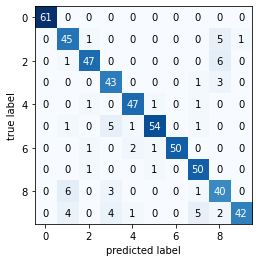

In [40]:
print('Gaussian Naive Bayes Classifier on digits dataset... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

### 2.2. SciKitLearn Digits Summarised

Reduce the `digits` data set to only contain three values for the attributes, e.g., `0` for _dark_, `1` for _grey_ and `2` for _light_, with _dark_, _grey_ and _light_. Split again into `70%` training and `30%` test data.

Bins:
*  Light: `0-4`
*  Grey: `5-10`
*  Dark: `11-16`

In [41]:
bin_bounds = [4, 10]
digits_data_summarised = np.digitize(digits.images, bins=bin_bounds, right=True)
digits_target_summarised = digits.target

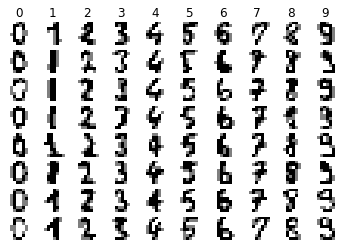

In [42]:
# Display random sample of images per class
n_samples = 8
n_classes = 10
for cls in range(n_classes):
    idxs = np.where(digits_target_summarised == cls)[0]
    idxs = np.random.choice(idxs, n_samples, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(n_samples, n_classes, i * n_classes + cls + 1)
        plt.axis('off')
        plt.imshow(digits_data_summarised[idx].reshape((8,8)).astype('uint8'), cmap=plt.cm.gray_r, interpolation='nearest')
        if i == 0:
            plt.title(str(cls))
plt.show()

In [43]:
X_train, X_test, y_train, y_test = train_test_split(digits_data_summarised, digits_target_summarised, test_size=0.3)

#### 2.2.1. SciKitLearn Gaussian Naive Bayes Classifier

In [44]:
# Reshape data to 2D
X_train = X_train.reshape((len(X_train), -1))
X_test = X_test.reshape((len(X_test), -1))

In [45]:
sklearnGNB.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [46]:
y_pred = sklearnGNB.predict(X_test)

SciKitLearn Gaussian Naive Bayes Classifier on digits summarised dataset... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       0.91      0.57      0.70        53
           2       0.94      0.69      0.80        49
           3       0.90      0.74      0.81        62
           4       0.96      0.89      0.93        57
           5       0.98      0.64      0.77        66
           6       0.94      0.96      0.95        46
           7       0.90      0.97      0.93        59
           8       0.44      0.98      0.61        47
           9       0.75      0.87      0.80        47

    accuracy                           0.82       540
   macro avg       0.87      0.83      0.83       540
weighted avg       0.88      0.82      0.83       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f71ab86d0>)

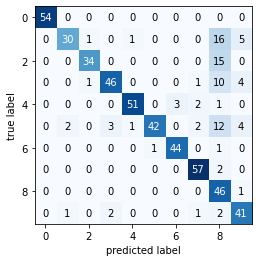

In [47]:
print('SciKitLearn Gaussian Naive Bayes Classifier on digits summarised dataset... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

#### 2.2.2. Nearest Centroid Classifier

In [48]:
ncc.fit(X_train, y_train)

In [49]:
y_pred = ncc.predict(X_test)

Nearest Centroid Classifier on digits summarised data... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.86      0.72      0.78        53
           2       0.91      0.86      0.88        49
           3       0.93      0.81      0.86        62
           4       1.00      0.98      0.99        57
           5       0.98      0.91      0.94        66
           6       0.96      0.98      0.97        46
           7       0.95      1.00      0.98        59
           8       0.83      0.85      0.84        47
           9       0.67      0.96      0.79        47

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.90       540
weighted avg       0.91      0.91      0.91       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6ec6a9d0>)

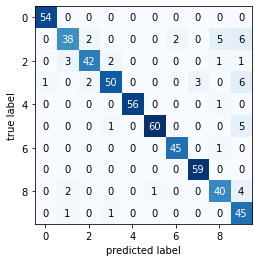

In [50]:
print('Nearest Centroid Classifier on digits summarised data... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

#### 2.2.3. Naive Bayes Classifier

In [51]:
n_samples, n_pixels = X_train.shape
dim = int(np.sqrt(n_pixels))

In [52]:
# Reshape data to 3D
X_train_nbc = X_train.reshape((len(X_train), dim, dim))
X_test_nbc = X_test.reshape((len(X_test), dim, dim))

In [53]:
nbc.fit(X_train_nbc, y_train)

In [54]:
y_pred = nbc.predict(X_test_nbc)

Naive Bayes Classifier on digits summarised data... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.87      0.75      0.81        53
           2       0.88      0.88      0.88        49
           3       0.96      0.79      0.87        62
           4       0.98      0.96      0.97        57
           5       1.00      0.91      0.95        66
           6       0.98      0.98      0.98        46
           7       0.94      1.00      0.97        59
           8       0.84      0.87      0.85        47
           9       0.71      0.98      0.82        47

    accuracy                           0.91       540
   macro avg       0.91      0.91      0.91       540
weighted avg       0.92      0.91      0.91       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6eb38c10>)

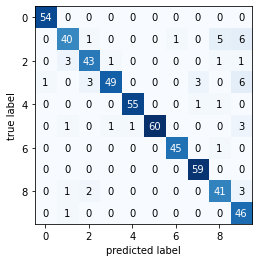

In [55]:
print('Naive Bayes Classifier on digits summarised data... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

#### 2.2.4. Gaussian Naive Bayes Classifier

In [56]:
gnbc.fit(X_train, y_train)

In [57]:
y_pred = gnbc.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2192: RuntimeWarning: divide by zero encountered in ? (vectorized)
  outputs = ufunc(*inputs)


Gaussian Naive Bayes Classifier on digits summarised dataset... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        54
           1       0.95      0.70      0.80        53
           2       0.95      0.84      0.89        49
           3       0.92      0.74      0.82        62
           4       0.96      0.93      0.95        57
           5       0.98      0.83      0.90        66
           6       1.00      0.96      0.98        46
           7       0.88      1.00      0.94        59
           8       0.64      0.98      0.77        47
           9       0.75      0.94      0.83        47

    accuracy                           0.89       540
   macro avg       0.90      0.89      0.89       540
weighted avg       0.91      0.89      0.89       540

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6e9f5250>)

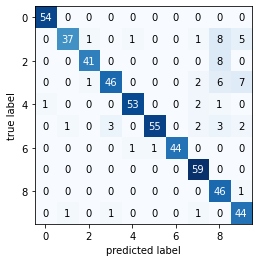

In [58]:
print('Gaussian Naive Bayes Classifier on digits summarised dataset... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(y_test, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(y_test, y_pred))

### 2.3. MNIST_Light

In [61]:
# ---------------------------------------------------------------- #
# This code is mainly from the EDAN95 fall term lab session No 6,
# provided by Volker Krueger
# ---------------------------------------------------------------- #
from PIL import Image
import glob

dir = 'src/MNIST_Light/*/*.png'

filelist = sorted(glob.glob(dir))
x = np.array([np.array(Image.open(fname)) for fname in filelist])

samples_per_class = 500
number_of_classes = 10

y = np.zeros(number_of_classes * samples_per_class, dtype=int)
for cls in range(1, number_of_classes):
    y[(cls*500):(cls+1)*500] = cls
    
train_features, test_features, train_labels, test_labels = train_test_split(x, y, test_size=0.3, random_state=42)
train_normalised = train_features.reshape(3500, 400) / 255.0
test_normalised = test_features.reshape(1500, 400) / 255.0

In [62]:
train_features.shape

(3500, 20, 20)

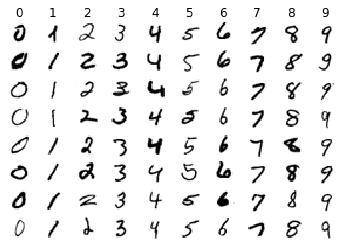

In [63]:
visualize_random(train_features, train_labels, examples_per_class=8)

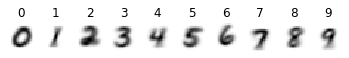

In [64]:
mean_image(train_features, train_labels, dim=20)

#### 2.3.1. SciKitLearn Gaussian Naive Bayes Classifier

In [65]:
sklearnGNB.fit(train_normalised, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [66]:
y_pred = sklearnGNB.predict(test_normalised)

SciKitLearn Gaussian Naive Bayes Classifier on MNIST_Light data... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.54      0.94      0.69       164
           1       0.71      0.94      0.81       152
           2       0.83      0.50      0.62       155
           3       0.83      0.53      0.65       154
           4       0.75      0.31      0.44       143
           5       0.67      0.16      0.25       141
           6       0.81      0.85      0.83       143
           7       0.83      0.82      0.83       158
           8       0.41      0.64      0.50       132
           9       0.60      0.84      0.70       158

    accuracy                           0.66      1500
   macro avg       0.70      0.65      0.63      1500
weighted avg       0.70      0.66      0.64      1500

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f71992c90>)

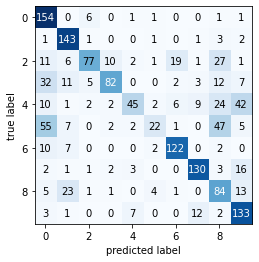

In [67]:
print('SciKitLearn Gaussian Naive Bayes Classifier on MNIST_Light data... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(test_labels, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(test_labels, y_pred))

#### 2.3.2. Nearest Centroid Classifier

In [68]:
ncc.fit(train_normalised, train_labels)

In [69]:
y_pred = ncc.predict(test_normalised)

Nearest Centroid Classifier on MNIST_Light data... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       164
           1       0.71      0.97      0.82       152
           2       0.84      0.73      0.78       155
           3       0.74      0.76      0.75       154
           4       0.75      0.76      0.75       143
           5       0.72      0.69      0.70       141
           6       0.90      0.86      0.88       143
           7       0.95      0.80      0.87       158
           8       0.79      0.72      0.75       132
           9       0.76      0.80      0.78       158

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.81      0.80      0.80      1500

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f71ed0f90>)

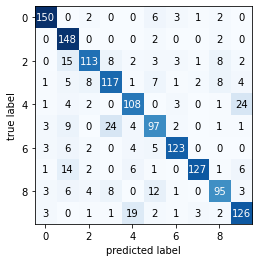

In [70]:
print('Nearest Centroid Classifier on MNIST_Light data... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(test_labels, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(test_labels, y_pred))

#### 2.3.3. Naive Bayes Classifier

In [71]:
n_samples, n_pixels = train_normalised.shape
dim = int(np.sqrt(n_pixels))

In [72]:
# Reshape data to 3D
train_normalised_nbc = train_normalised.reshape((len(train_normalised), dim, dim))
test_normalised_nbc = test_normalised.reshape((len(test_normalised), dim, dim))

In [73]:
nbc.fit(train_normalised_nbc, train_labels, data="MNIST_Light")

In [74]:
y_pred = nbc.predict(test_normalised_nbc)

Naive Bayes Classifier on MNIST_Light data... 

----------Classification Report-----
              precision    recall  f1-score   support

           0       0.70      0.18      0.29       164
           1       0.32      0.99      0.48       152
           2       0.75      0.04      0.07       155
           3       0.56      0.25      0.35       154
           4       0.25      0.17      0.21       143
           5       0.24      0.04      0.07       141
           6       0.69      0.50      0.58       143
           7       0.38      0.09      0.14       158
           8       0.15      0.15      0.15       132
           9       0.21      0.66      0.32       158

    accuracy                           0.31      1500
   macro avg       0.42      0.31      0.27      1500
weighted avg       0.43      0.31      0.27      1500

----------Confusion Matrix----------


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9f6dbe19d0>)

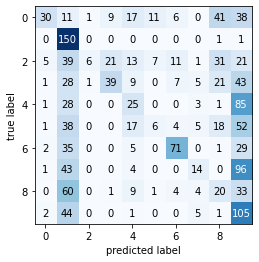

In [75]:
print('Naive Bayes Classifier on MNIST_Light data... \n')
print('-'*10 + 'Classification Report' + '-'*5)
print(metrics.classification_report(test_labels, y_pred))
print('-'*10 + 'Confusion Matrix' + '-'*10)
plot_confusion_matrix(metrics.confusion_matrix(test_labels, y_pred))

## Credits
This assignment was prepared by E.A Topp et al., HT2019 (link [here](http://cs.lth.se/edan95/lab-programming-assignments/lab-session-5)).